# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [1570]:
np.random.seed(0)

In [1571]:
# From the assignment; The function that we are goint to approximate
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [1572]:
# Generate samples from the FrankeFunction with some optional noise
def franke_sampler(x, y, noise=.1):
    f = FrankeFunction(x, y).reshape(len(x), 1)
    var_eps = noise * np.var(f)
    z = f + np.sqrt(var_eps)*np.random.randn(len(x), 1)
    return (z, f, var_eps)

In [1573]:
# Create a mesh with sn uniform randomly scattered points in the rectangle (x_start, y_start), (x_end, y_end). Returned ndarrays have shape (sn, 1)
def randmesh(sn=100, x_start=0., y_start=0., x_end=1., y_end=1.):
    x = np.random.uniform(x_start, x_end, (sn, 1))
    y = np.random.uniform(y_start, y_end, (sn, 1))
    return (x, y)

In [1574]:
# Make design matrix with polinomial degree np in two variables
def make_design_matrix(x, y, pn=5):
    X = np.ndarray([len(x), int((pn+1)*(pn+2)/2)])

    ex = [0]*int((pn+1)*(pn+2)/2)
    ey = [0]*int((pn+1)*(pn+2)/2)
    kx = ky = 0
    for i in range(pn+1):
        for j in range(i+1):
            ex[kx] = j
            kx += 1
        for j in range(i,-1,-1):
            ey[ky] = j
            ky += 1

    for i, (xi, yi) in enumerate(zip(x, y)):
        X[i,:] = [(xi**px)*(yi**py) for px, py in zip(ex, ey)]
    
    return X

In [1575]:
# Defining some useful functions
def mse(y, y_tilde):
    return np.mean(np.mean((y - y_tilde)**2, axis=1, keepdims=True))

def r2(y, y_tilde):
    return 1 - sum((y - np.mean(y_tilde, axis=1, keepdims=True))**2)/sum((y - np.mean(y))**2)

def bias(f, y_tilde):
    return np.mean((f - np.mean(y_tilde, axis=1, keepdims=True))**2)

def var(y):
    return np.mean(np.var(y, axis=1, keepdims=True))

def scale(X):
    if X.shape[1] == 1:
        return X
    X -= np.mean(X[:,1:])
    X[:,0] = 1
    return X

# NOTE: Choose k such that len(z)%k is zero, ie the split is even!
def split(y, k):
    n = len(y)
    s = n//k  # samples in each split
    last_idx = n - n%k  # remove overshooting samples
    test_splits = [list(range(i, i+s)) for i in range(0, last_idx, s)]
    train_splits = [list(set(range(last_idx)) - set(test_split)) for test_split in test_splits]
    return zip(train_splits, test_splits)

In [1586]:
x, y = randmesh(sn=1000)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=.1)
max_pol_order = 30
bootstraps = 30

## MSE of train vs test data

In [1577]:
mse_df = DataFrame()
mse_df["pol order"] = list(range(max_pol_order+1))
mse_df["mse test"] = np.ndarray(max_pol_order+1)
mse_df["mse train"] = np.ndarray(max_pol_order+1)

mse_train = np.ndarray(bootstraps)
mse_test = np.ndarray(bootstraps)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test = skl.model_selection.train_test_split(X, z, train_size=.7)
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        mse_train[bs] = mse(z_resampled, X_resampled @ beta_hat)
        mse_test[bs] = mse(z_test, X_test @ beta_hat)
    
    mse_df.at[pn, "mse train"] = np.mean(mse_train)
    mse_df.at[pn, "mse test"] = np.mean(mse_test)

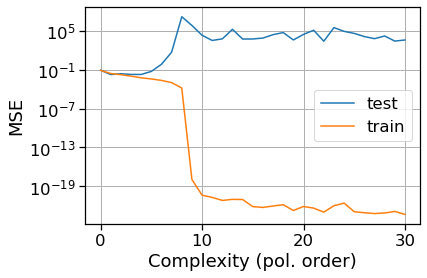

In [1578]:
ax = mse_df.plot(x="pol order", logy=True)
ax.legend(["test", "train"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

## Bias-variance tradeoff with Bootstrap resampling

In [1579]:
bivar_df = DataFrame()
bivar_df["pol order"] = list(range(max_pol_order+1))
bivar_df["mse"] = np.ndarray(max_pol_order+1)
bivar_df["bias"] = np.ndarray(max_pol_order+1)
bivar_df["var"] = np.ndarray(max_pol_order+1)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test, f_train, f_test = skl.model_selection.train_test_split(X, z, f, train_size=.7)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        z_test_tilde[:, bs] = (X_test @ beta_hat).ravel()
    
    bivar_df.at[pn, "mse"] = mse(z_test, z_test_tilde)
    bivar_df.at[pn, "bias"] = bias(z_test, z_test_tilde)
    bivar_df.at[pn, "var"] = var(z_test_tilde)

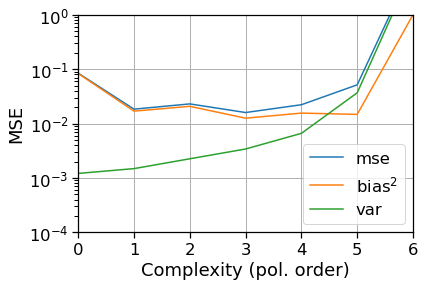

In [1580]:
ax = bivar_df.plot(x="pol order", logy=True)
ax.legend(["mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")
ax.set_xlim(0,6)
ax.set_ylim(1E-4,1)
ax.grid(True)
plt.show()

## MSE with $k$-fold cross-validation resampling
The data is randomized, so we don't need to do that again.

In [1581]:
k = 10  ## NOTE: Choose k such that len(z)%k is zero, ie the split is even!
s = len(z)//k  ## samples in each split
last_idx = len(z) - len(z)%k
test_splits = [range(i, i+s) for i in range(0, last_idx, s)]
train_splits = [list(set(range(last_idx)) - set(rng)) for rng in test_splits]

In [1582]:
k_mse_df = DataFrame()
k_mse_df["pol order"] = list(range(max_pol_order+1))
k_mse_df["mse test"] = np.ndarray(max_pol_order+1)
k_mse_df["mse train"] = np.ndarray(max_pol_order+1)

mse_train = np.ndarray(k)
mse_test = np.ndarray(k)

for pn in k_mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train = scale(X_train)
    X_test = scale(X_test)

    for i, (train_split, test_split) in enumerate(zip(train_splits, test_splits)):
        X_train = X[train_split]
        X_test = X[test_split]
        z_train = z[train_split]
        z_test = z[test_split]
    
        beta_hat = np.linalg.pinv(X_train) @ z_train
        z_train_tilde = X_train @ beta_hat
        z_test_tilde = X_test @ beta_hat

        mse_train[i] = mse(z_train, z_train_tilde)
        mse_test[i] = mse(z_test, z_test_tilde)
    
    k_mse_df.at[pn, "mse train"] = np.mean(mse_train)
    k_mse_df.at[pn, "mse test"] = np.mean(mse_test)


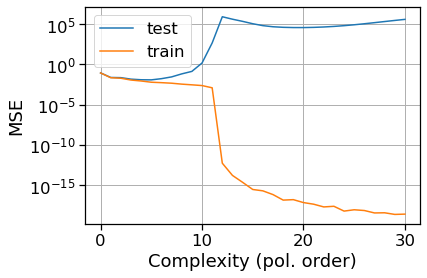

In [1583]:
ax = k_mse_df.plot(x="pol order", logy=True)
ax.legend(["test", "train"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

## Ridge regression

In [1626]:
num_lambdas = 20
max_pol = 9

train_df = DataFrame()
train_df["lambda"] = np.logspace(-5, 2, num_lambdas)
test_df = DataFrame()
test_df["lambda"] = np.copy(train_df["lambda"])

mse_train = np.ndarray(bootstraps)
mse_test = np.ndarray(bootstraps)

for pn in range(1,max_pol+1, 2):
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test = skl.model_selection.train_test_split(X, z, train_size=.5)
    X_train = scale(X_train)
    X_test = scale(X_test)
    n, p = X_train.shape
    
    train_df[f"{pn}"] = np.ndarray(num_lambdas)
    test_df[f"{pn}"] = np.ndarray(num_lambdas)
    
    for i, lmd in enumerate(train_df["lambda"]):
        L = lmd*np.identity(p)

        for bs in range(bootstraps):
            X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)      
            X_resampled = X_resampled[:p,:p]
            z_resampled = z_resampled[:p]

            X_shuff, z_shuff = skl.utils.shuffle(X_test, z_test, random_state=bs)
            X_shuff = X_shuff[:p,:p]
            z_shuff = z_shuff[:p]

            U, s, Vt = np.linalg.svd(X_resampled)
            S = np.diag(s)

            beta_hat = Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T @ z_resampled
            mse_train[bs] = np.mean((z_resampled - X_resampled @ beta_hat)**2)
            mse_test[bs] = mse(z_shuff, X_shuff @ beta_hat)

        train_df.at[i, f"{pn}"] = np.mean(mse_train)
        test_df.at[i, f"{pn}"] = np.mean(mse_test)
    

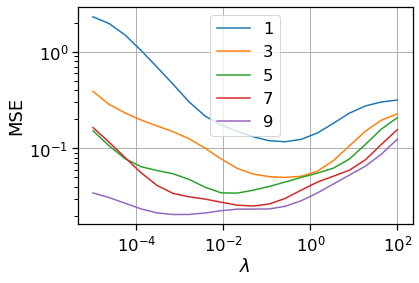

In [1629]:
ax = test_df.plot(x="lambda", logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()